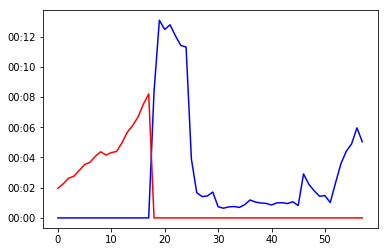

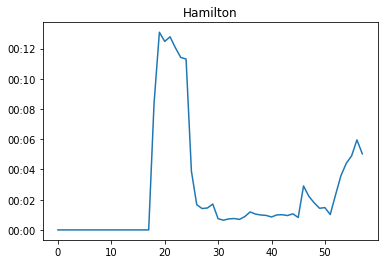

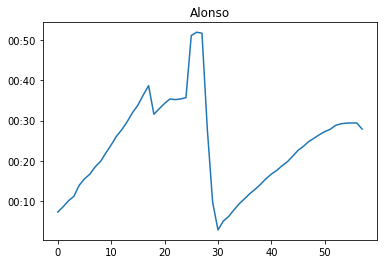

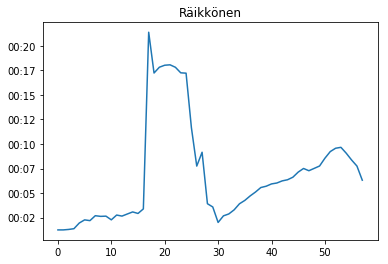

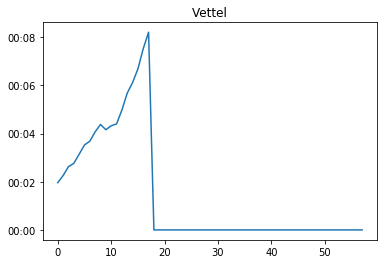

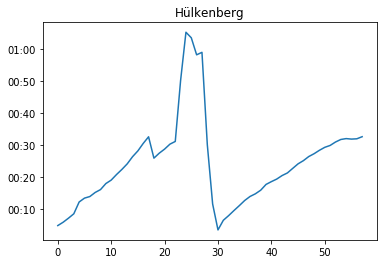

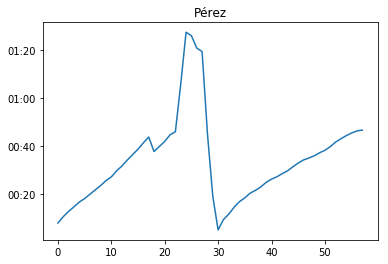

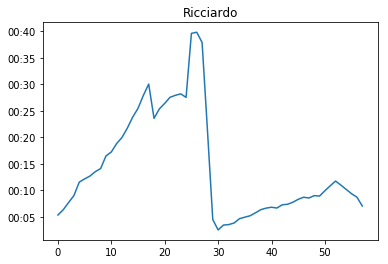

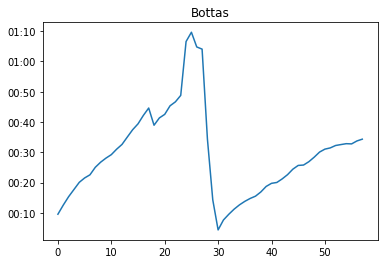

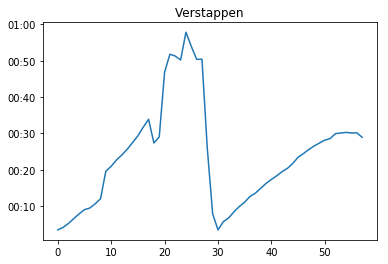

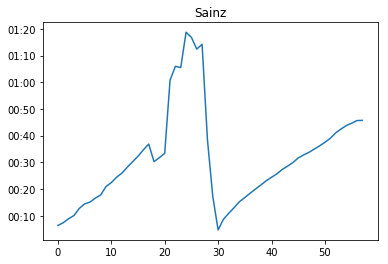

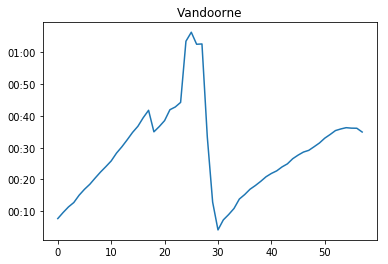

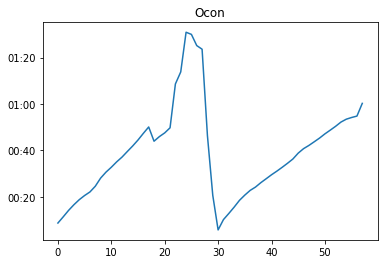

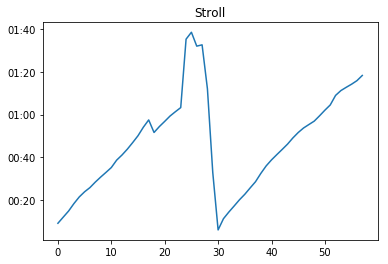

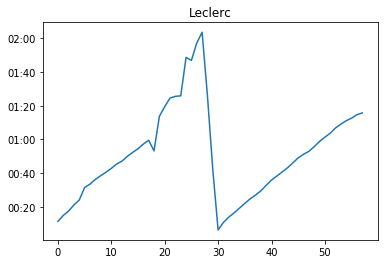

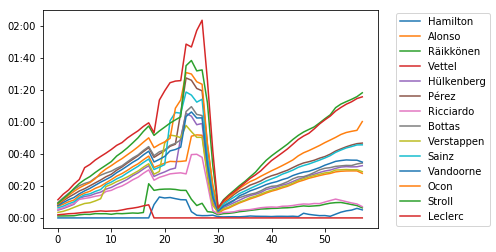

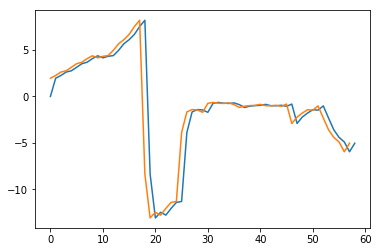

Lap_time_differences.ipynb:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  "source": [


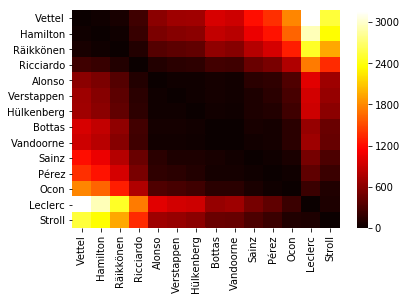

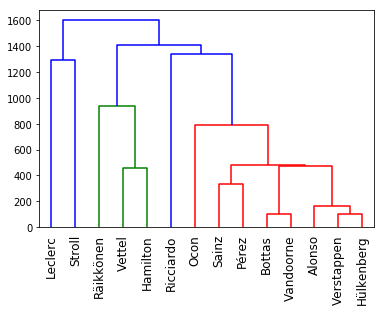

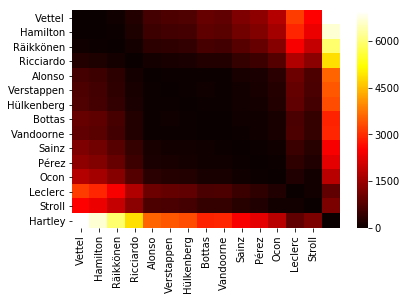

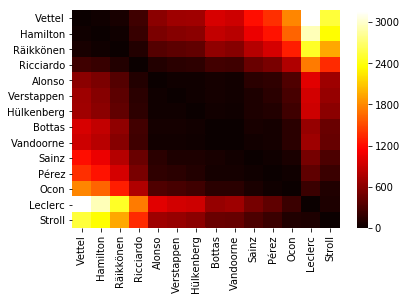

Lap_time_differences.ipynb:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  {
Lap_time_differences.ipynb:7: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  "outputs": [],


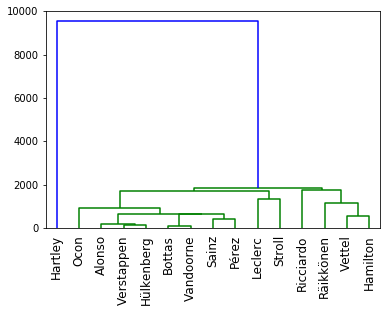

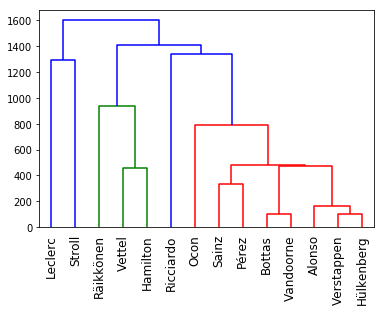

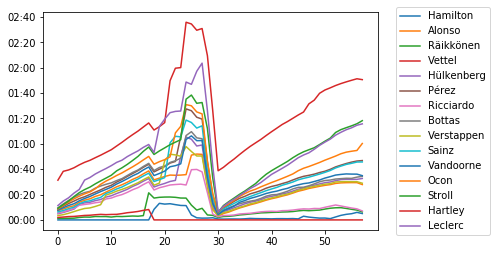

Expected:   125584
Calculated: 125584
Expected:   108016
Calculated: 108016
Expected:   207671
Calculated: 207671
Expected:   124389
Calculated: 124389
Expected:   110162.0
Calculated: 110162


In [22]:
%run Lap_time_differences.ipynb

# Fill in missing values
Now that we decided on a penalty for DNF's, we should fill in missing data and write it to text files.

In [23]:
# Get the 2018 races' ids
df_races = pd.read_csv("f1db_csv/races.csv")
df_results = pd.read_csv("f1db_csv/results.csv")

races18 = (df_races >> mask(X.year==2018)).raceId.values

We now go to each race and determine which drivers did not finish the race.

The status.csv file contains codes that describe if the driver finished the race, and if not, why. The most important codes for us are 1 (finished) and 11 thru 19 (+1 lap, +2 laps, ..., +9 laps). We will not touch drivers with code 1. We will use using fill_laps_behind for codes 11 to 19, and fill_laps for the others (this contains the penalties).

In [24]:
def fill_missing_laps(method=slowest_time):
    FilledLapTimes = lap_times.copy()
    for race in races18:
        # We filter the drivers that did not finish
        race_results = (df_results >>
                        mask(X.raceId==race, X.statusId != 1) >>
                        select(X.driverId, X.statusId))

        # If there are no entries, all the drivers finished the race
        if(race_results.size==0):
            continue

        # Otherwise...
        drivers_dnf = race_results.driverId.values
        status = race_results.statusId.values

        n = len(drivers_dnf)

        # We populate each driver's lap times
        for i in range(n):
            driver = drivers_dnf[i]
            s = int(status[i])

            # If the status is between 11 and 19, we fill laps behind
            if(11 <= s <= 19):
                FilledLapTimes = fill_laps_behind(FilledLapTimes, race, driver)
            # If not, we penalize
            else:
                FilledLapTimes = fill_laps(FilledLapTimes, race, driver, method=method)
    
    # Sort the data frame as we need laps in increasing order (and nice looking df's are always good)
    FilledLapTimes = (FilledLapTimes >>
                      arrange(X.raceId, X.driverId, X.lap))
    
    return(FilledLapTimes)

In [25]:
SlowestLapTimes = fill_missing_laps(method=slowest_time)
print(SlowestLapTimes.shape)

(25280, 6)


In [26]:
PositionLapTimes= fill_missing_laps(method=same_position)
print(PositionLapTimes.shape)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [27]:
AverageLapTimes = fill_missing_laps(method=average_time)
print(AverageLapTimes.shape)

(25280, 6)


In [28]:
SlowestLapTimes.to_csv("f1db_csv/SlowestLapTimes.csv")
AverageLapTimes.to_csv("f1db_csv/AverageLapTimes.csv")